# Calculations with Reference States

## Experimental Reference States: Formation and Mixing Energy

By default, energies calculated with pycalphad (e.g. `GM`, `HM`, etc.) are the absolute energies as defined in the database and are not calculated with respect to any reference state.

pycalphad allows the reference for any property to be set to arbitrary phases and temperature/pressure conditions through the `ReferenceState` meta-property, which creates new properties for the specified property that are referenced to the specified reference state.

### Enthalpy of mixing

The enthalpy of mixing in the liquid, analogous to what would be measured experimentally, is calculated and plotted below with the reference states of the pure elements both set to the liquid phase. No temperature and pressure are specified as we would like the reference state to be calculated with respect to the calculation temperature.

In [6]:
%matplotlib inline

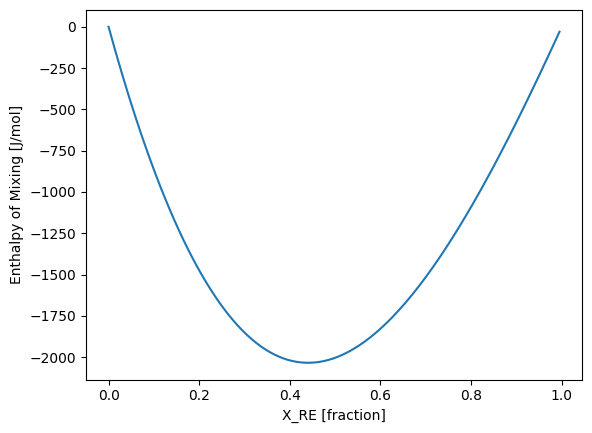

In [7]:
from pycalphad import Workspace, variables as v
from pycalphad.property_framework import ReferenceState

wks = Workspace("nbre_liu.tdb", ["NB", "RE", "VA"], ["LIQUID_RENB"],
                {v.P: 101325, v.T: 2800, v.X("RE"): (0, 1, 0.005)})

ref = ReferenceState([("LIQUID_RENB", {v.X("RE"): 0}),
                      ("LIQUID_RENB", {v.X("RE"): 1})
                     ], wks)

ref_enthalpy = ref('HM')
ref_enthalpy.display_name = 'Enthalpy of Mixing'

wks.plot(v.X('RE'), ref_enthalpy)

### Enthalpy of formation - convex hull

Formation enthalpies are often reported in the literature with respect to the pure elements in their stable phase at 298.15 K. The enthalpy of formation of the phases in equilibrium, analogous to what would be measured experimentally, is calculated and plotted below for T=2800 K, with the reference states of the pure elements both set to the stable phases and fixed at 298.15 K and 1 atm.

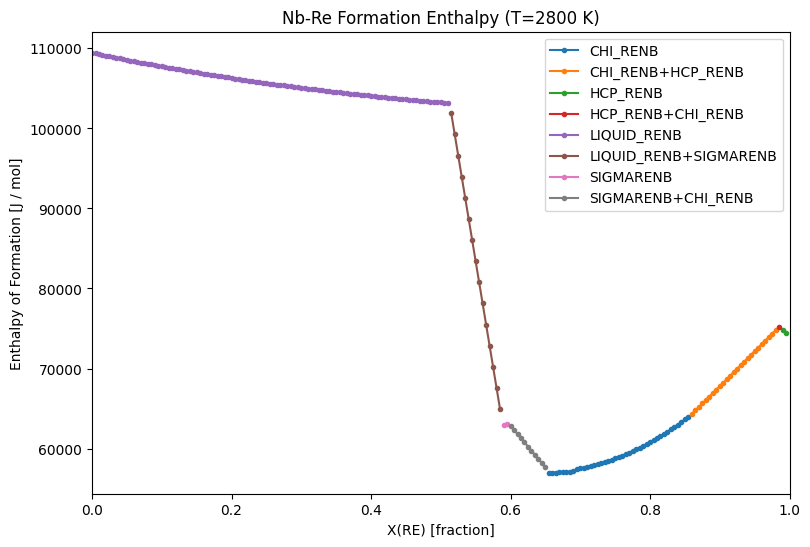

In [8]:
from pycalphad import Database, Workspace, as_property, variables as v
from pycalphad.property_framework import ReferenceState
import matplotlib.pyplot as plt
import numpy as np

dbf_nbre = Database("nbre_liu.tdb")

wks2 = Workspace(dbf_nbre, ["NB", "RE", "VA"], sorted(dbf_nbre.phases.keys()),
                 {v.P: 101325, v.T: 2800, v.X("RE"): (0, 1, 0.005)})

ref2 = ReferenceState([("BCC_RENB", {v.X("RE"): 0, v.T: 298.15}), # NB
                       ("HCP_RENB", {v.X("RE"): 1, v.T: 298.15})  # RE
                     ], wks2)

x_re, enthalpy_of_formation = wks2.get(v.X('RE'), ref2('HM'))

# Find the groups of stable phases in equilibrium e.g. [CHI_RENB] and [CHI_RENB, HCP_RENB]
unique_phase_sets = np.unique(wks2.eq.Phase.squeeze(), axis=0)

# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for phase_set in unique_phase_sets:
    label = '+'.join([ph for ph in phase_set if ph != ''])
    # composition indices with the same stable set of phases
    unique_phase_idx = np.nonzero(np.all(wks2.eq.Phase.squeeze() == phase_set, axis=1))[0]
    ax.plot(x_re[unique_phase_idx], enthalpy_of_formation[unique_phase_idx], marker='.', label=label)
ax.set_xlim((0, 1))
ax.set_xlabel(f'X(RE) [{v.X("RE").implementation_units}]')
ax.set_ylabel(f'Enthalpy of Formation [{as_property("HM").implementation_units}]')
ax.set_title('Nb-Re Formation Enthalpy (T=2800 K)')
ax.legend()
plt.show()